In [2]:
import pandas as pd
from copy import deepcopy
from collections import Counter
import os

from utils_fetch import start_date, end_date, query_terms_list, year_list, DATA_DIR

/home/toharhymes/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
def clean_series(series: pd.Series) -> pd.Series:
    # Apply the transformations to each element of the series
    return series.astype(str).str.strip().str.rstrip('.')

# def clean_series(series: pd.Series) -> pd.Series:
#     # Apply the transformations to each element of the series
#     return series

def clean_abstract_column(df):
    # Check if 'abstract' column exists
    if 'abstract' in df.columns:
        # Apply the cleaning process to each entry in the 'abstract' column
        df['abstract'] = clean_series(df['abstract'].str.replace('<i>', '', regex=False)\
                                       .str.replace('</i>', '', regex=False)\
                                       .str.replace('<b>', '', regex=False)\
                                       .str.replace('</b>', '', regex=False)\
                                       .str.replace('\n', ' ', regex=False))
    if 'title' in df.columns:
        # Apply the cleaning process to each entry in the 'abstract' column
        df['title'] = clean_series(df['title'].str.replace('<i>', '', regex=False)\
                                       .str.replace('</i>', '', regex=False)\
                                       .str.replace('<b>', '', regex=False)\
                                       .str.replace('</b>', '', regex=False)\
                                       .str.replace('\n', ' ', regex=False))
        
    else:
        print("The 'abstract' column does not exist in the DataFrame.")
    
    return df

def merge_by_title_and_abstract(df):
    # First, handle cases where titles are the same
    grouped_by_title = df.groupby('title', as_index=False).agg({
        'abstract': lambda x: '\n==========\n'.join([str(item) for item in set(x) if pd.notna(item)]),
        'source': lambda x: ','.join(set(x))
    })
    
    # Next, handle cases where abstracts are the same but titles are different
    grouped_by_abstract = grouped_by_title.groupby('abstract', as_index=False).agg({
        'title': lambda x: '\n==========\n'.join([str(item) for item in set(x) if pd.notna(item)]),
        'source': lambda x: ','.join(set(x))
    })
    
    return grouped_by_abstract[['title', "abstract", 'source']]

# Load your data (assuming it's a CSV file)
df = pd.read_csv(os.path.join(DATA_DIR, '0_all.csv')) [['title', 'abstract', 'source']]
print("Total:", df.shape)
print("By source:", Counter(df.source))
# display(df[df.title.fillna('').str.contains('varchat', case=False)])
df = clean_abstract_column(df)
print(df.shape)
df = merge_by_title_and_abstract(df)
df['title_abstract'] = (df['title'] + ' ' + df['abstract']).astype(str)
df['title'] = df['title'].astype(str)
df['abstract'] = df['abstract'].astype(str)
df

Total: (57558, 3)
By source: Counter({'PubMed': 34923, 'biorxiv': 11213, 'arXiv': 5972, 'medrxiv': 5450})
(57558, 3)


,title,abstract,source,title_abstract
0,ArcSin: Adaptive ranged cosine Similarity inje...,"""A data scientist is tasked with developing a ...",arXiv,ArcSin: Adaptive ranged cosine Similarity inje...
1,Can Large Language Models Unlock Novel Scienti...,"""An idea is nothing more nor less than a new c...",arXiv,Can Large Language Models Unlock Novel Scienti...
2,Relationship of Burnout and Extra-Curricular A...,"""Burnout syndrome (BS)"" is a work-associated c...",PubMed,Relationship of Burnout and Extra-Curricular A...
3,Great Toe Tip Reconstruction after Severe COVI...,"""COVID toe,"" one of the extrapulmonary disorde...",PubMed,Great Toe Tip Reconstruction after Severe COVI...
4,A non-adaptive explanation for macroevolutiona...,"""Complex multicellularity"", conventionally def...",biorxiv,A non-adaptive explanation for macroevolutiona...
...,...,...,...,...
51608,Preliminary discrimination and evaluation of c...,•Evaluation of making up ChatGPT4o in the prel...,PubMed,Preliminary discrimination and evaluation of c...
51609,Varying presentations of immune checkpoint inh...,•ICI-associated myocarditis is a rare clinical...,PubMed,Varying presentations of immune checkpoint inh...
51610,A two-year longitudinal observational study of...,•Neurodegeneration precede microcirculatory de...,PubMed,A two-year longitudinal observational study of...
51611,Recommendations on data sharing in HIV drug re...,• Human immunodeficiency virus (HIV) drug resi...,PubMed,Recommendations on data sharing in HIV drug re...


In [4]:
len(df.title.unique())

51613

## Raw check

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_article_source_histogram(df, save_path=None, up_size=100, title='Number of Articles from Each Source', ax=None):
    import matplotlib.pyplot as plt
    import seaborn as sns

    df_cleaned = df.dropna(subset=['title', 'abstract'], how='all')
    article_count_per_source = df_cleaned['source'].value_counts().reset_index()
    article_count_per_source.columns = ['source', 'count']

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    sns.barplot(ax=ax, x='source', y='count', data=article_count_per_source,
                palette='pastel', edgecolor='black', linewidth=1.5)

    for index, row in article_count_per_source.iterrows():
        ax.text(index, row['count'] + up_size, int(row['count']), color='black', ha="center", fontsize=10)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Source', fontsize=12)
    ax.set_ylabel('Number of Articles', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=12)
    fig.subplots_adjust(bottom=0.2)  # or use tight_layout()
    ax.tick_params(axis='y', labelsize=12)

    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, format='pdf')

    return fig, ax

In [58]:
from pprint import pprint

pprint(Counter(df.source))
doubled_sources = {
    "PubMed,biorxiv,biorxiv": "PubMed,biorxiv",
    "biorxiv,PubMed,biorxiv": "PubMed,biorxiv",
    "PubMed,PubMed,arXiv": "PubMed,arXiv",
    "PubMed,medrxiv,medrxiv": "PubMed,medrxiv",
    "PubMed,arXiv,PubMed": "PubMed,arXiv",
    "arXiv,PubMed": "PubMed,arXiv",
    "biorxiv,PubMed": "PubMed,biorxiv",
    "medrxiv,PubMed": "PubMed,medrxiv",
    "arXiv,PubMed,PubMed": "PubMed,arXiv",
    "arXiv,PubMed,biorxiv": "PubMed,arXiv,biorxiv",
    "arXiv,PubMed,medrxiv": "PubMed,arXiv,medrxiv",
    "medrxiv,arXiv":"arXiv,medrxiv",
    'biorxiv,arXiv':"arXiv,biorxiv",
    'medrxiv,medrxiv,PubMed': "PubMed,medrxiv",
    'biorxiv,arXiv,PubMed': "PubMed,arXiv,biorxiv",
    'medrxiv,arXiv,PubMed': "PubMed,arXiv,medrxiv",
    "Pubmed": "PubMed",
    'arxiv': 'arXiv',
    'bioRxiv': 'biorxiv',
    'medrxiv,pubmed': 'PubMed,medrxiv',
    'PubMed, medrxiv': 'PubMed,medrxiv',
     "PubMed, biorxiv": "PubMed,biorxiv",
    "PubMed, arXiv": "PubMed,arXiv",
    'medrxiv, pubmed': 'PubMed,medrxiv',
    'medrxiv, arXiv,PubMed': "PubMed,arXiv,medrxiv",
    "biorxiv, PubMed": "PubMed,biorxiv",
    'medrxiv,PubMed,medrxiv': "PubMed,medrxiv",
    "arXiv,biorxiv,PubMed": "PubMed,arXiv,biorxiv",
}
for key, value in doubled_sources.items():
    df.loc[df.source == key, "source"] = value

Counter(df.source)

Counter({'PubMed': 32462,
         'biorxiv': 8405,
         'arXiv': 5725,
         'medrxiv': 4370,
         'PubMed,arXiv': 215,
         'PubMed,medrxiv': 213,
         'PubMed,biorxiv': 196,
         'arXiv,medrxiv': 16,
         'arXiv,biorxiv': 7,
         'PubMed,arXiv,biorxiv': 2,
         'biorxiv,medrxiv': 1,
         'PubMed,arXiv,medrxiv': 1})


Counter({'PubMed': 32462,
         'biorxiv': 8405,
         'arXiv': 5725,
         'medrxiv': 4370,
         'PubMed,arXiv': 215,
         'PubMed,medrxiv': 213,
         'PubMed,biorxiv': 196,
         'arXiv,medrxiv': 16,
         'arXiv,biorxiv': 7,
         'PubMed,arXiv,biorxiv': 2,
         'biorxiv,medrxiv': 1,
         'PubMed,arXiv,medrxiv': 1})

In [59]:
sum(list(Counter(df.source).values()))

51613

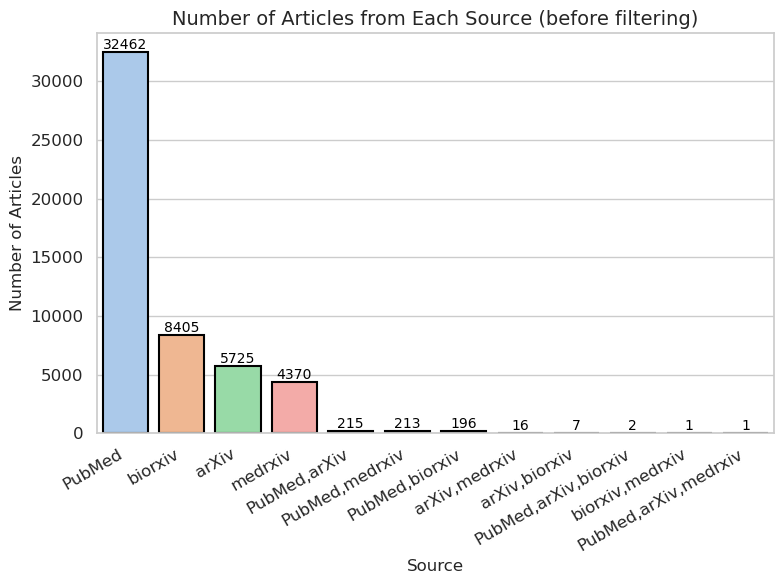

In [60]:
# Plot the histogram for the first time with all articles
initial_histogram = plot_article_source_histogram(df, save_path="imgs/Fig2_a.pdf", title='Number of Articles from Each Source (before filtering)', up_size=250)

In [61]:
df.to_csv(os.path.join(DATA_DIR, "cleaned.csv"), index=False)
df_cleaned = df

## Basic text stuff

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [11]:
# Example function for TF-IDF and frequency (count) analysis
def extract_tfidf_and_frequency(df, text_column):
    # TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[text_column])
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

    # Frequency (Count) Vectorizer
    count_vectorizer = CountVectorizer(stop_words='english', max_features=100)
    count_matrix = count_vectorizer.fit_transform(df[text_column])
    count_feature_names = count_vectorizer.get_feature_names_out()
    count_df = pd.DataFrame(count_matrix.toarray(), columns=count_feature_names)

    return tfidf_df, count_df

# Function to handle title, abstract, and both
def analyze_title_abstract(df):
    # TF-IDF and frequency for title
    title_tfidf, title_count = extract_tfidf_and_frequency(df, 'title')

    # TF-IDF and frequency for abstract
    abstract_tfidf, abstract_count = extract_tfidf_and_frequency(df, 'abstract')

    # TF-IDF and frequency for title + abstract
    title_abstract_tfidf, title_abstract_count = extract_tfidf_and_frequency(df, 'title_abstract')

    return title_tfidf, title_count, abstract_tfidf, abstract_count, title_abstract_tfidf, title_abstract_count




def plot_top_terms(df, title, top_n=20):
    """
    Plots the top N terms from a DataFrame where each column represents a term
    and each row represents a document.
    """
    # Get average scores per term
    term_scores = df.mean().sort_values(ascending=False).head(top_n)
    
    # Create a DataFrame for plotting
    term_df = pd.DataFrame({'term': term_scores.index, 'score': term_scores.values})
    
    # Plotting using seaborn and pastel colors
    sns.set(style="whitegrid", palette="pastel")
    plt.figure(figsize=(10, 20))
    sns.barplot(x="score", y="term", data=term_df, palette="pastel")
    plt.title(f"Top {top_n} Terms for {title}")
    plt.xlabel("Score")
    plt.ylabel("Term")
    plt.show()

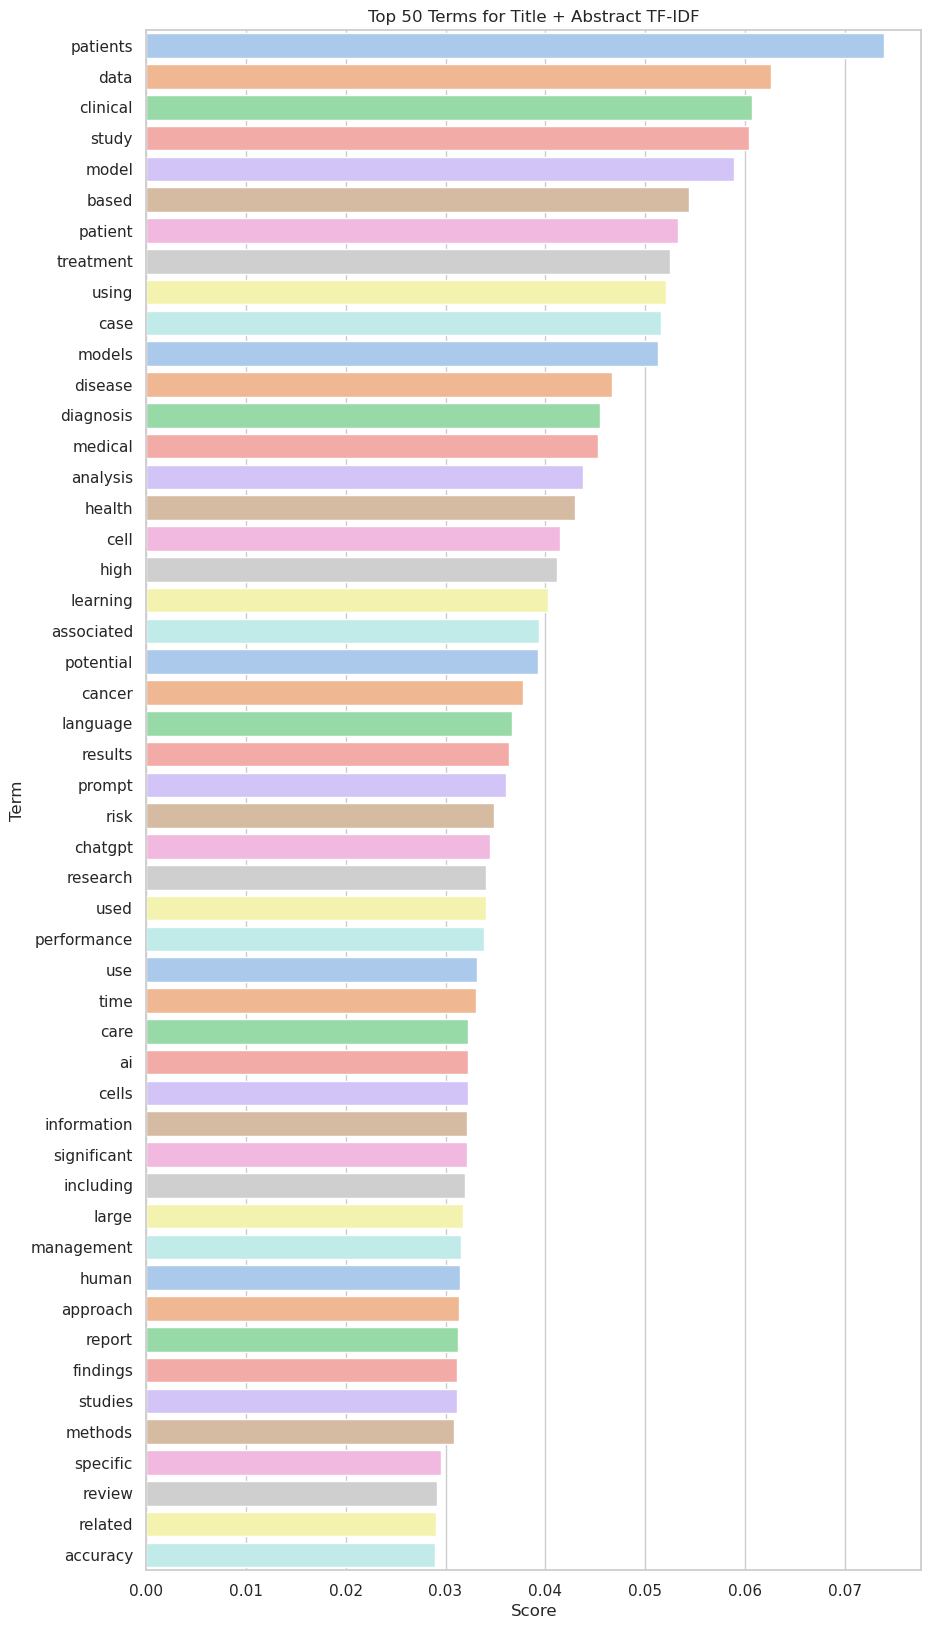

In [12]:
title_tfidf, title_count, abstract_tfidf, abstract_count, title_abstract_tfidf, title_abstract_count = analyze_title_abstract(df_cleaned)


# Example usage
# # Plot for title TF-IDF
# plot_top_terms(title_tfidf, "Title TF-IDF")
# # # Plot for title count
# # plot_top_terms(title_count, "Title Term Frequency")

# # Plot for abstract TF-IDF
# plot_top_terms(abstract_tfidf, "Abstract TF-IDF")
# # # Plot for abstract count
# # plot_top_terms(abstract_count, "Abstract Term Frequency")

# Plot for combined title and abstract TF-IDF
plot_top_terms(title_abstract_tfidf, "Title + Abstract TF-IDF", 50)
# # Plot for combined title and abstract count
# plot_top_terms(title_abstract_count, "Title + Abstract Term Frequency")

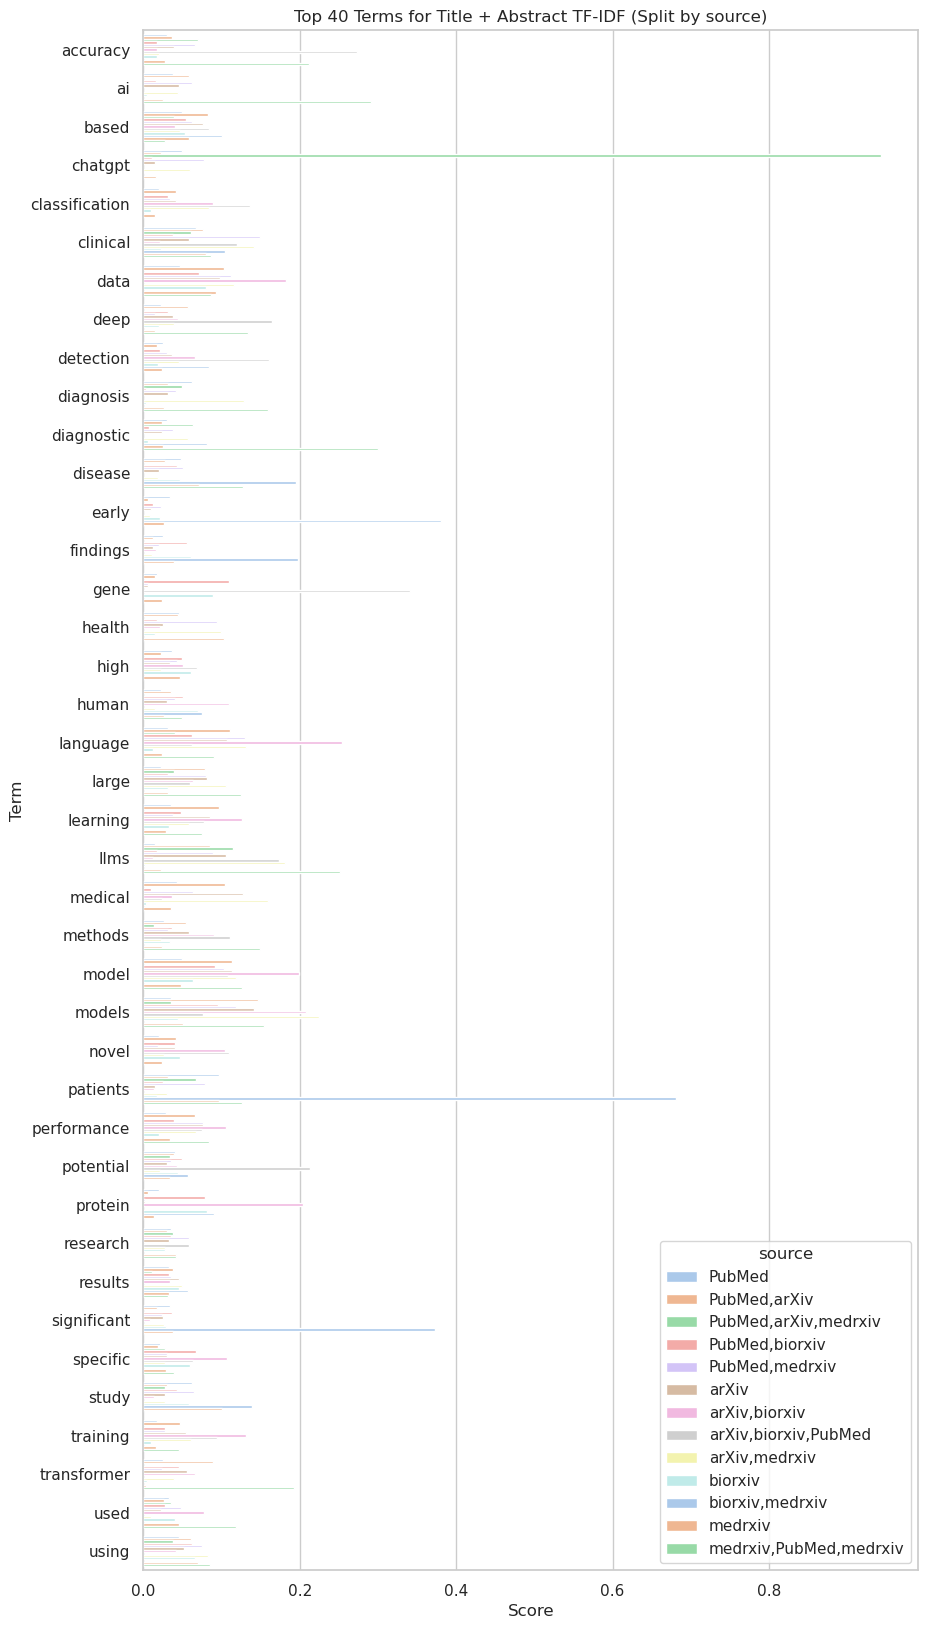

In [13]:

def plot_top_terms_with_source(df, source_col, title, top_n=40):
    """
    Plots the top N terms from a DataFrame where each column represents a term
    and each row represents a document, splitting bars based on the source column.
    """
    # Melt the dataframe to long format for seaborn, keeping the source column
    df_long = df.melt(id_vars=[source_col], var_name="term", value_name="score")
    
    # Group by source and term, and compute mean score per group
    df_grouped = df_long.groupby([source_col, "term"]).mean().reset_index()
    
    # Select the top N terms by average score across all sources
    top_terms = df_grouped.groupby("term")["score"].mean().sort_values(ascending=False).head(top_n).index
    df_top = df_grouped[df_grouped["term"].isin(top_terms)]
    
    # Plotting
    sns.set(style="whitegrid", palette="pastel")
    plt.figure(figsize=(10, 20))
    
    # Create a grouped bar plot where bars are split by source
    sns.barplot(x="score", y="term", hue=source_col, data=df_top, palette="pastel")
    
    # Customize the plot
    plt.title(f"Top {top_n} Terms for {title} (Split by {source_col})")
    plt.xlabel("Score")
    plt.ylabel("Term")
    plt.legend(title=source_col)
    plt.show()

# Example usage:
# Assuming 'source' column is available in your dataframe (e.g., journal name, study type)
# Plot for title+abstract TF-IDF, splitting bars by source
plot_top_terms_with_source(title_abstract_tfidf.assign(source=df['source']), 'source', "Title + Abstract TF-IDF")

## Same for bigrams and trigrams

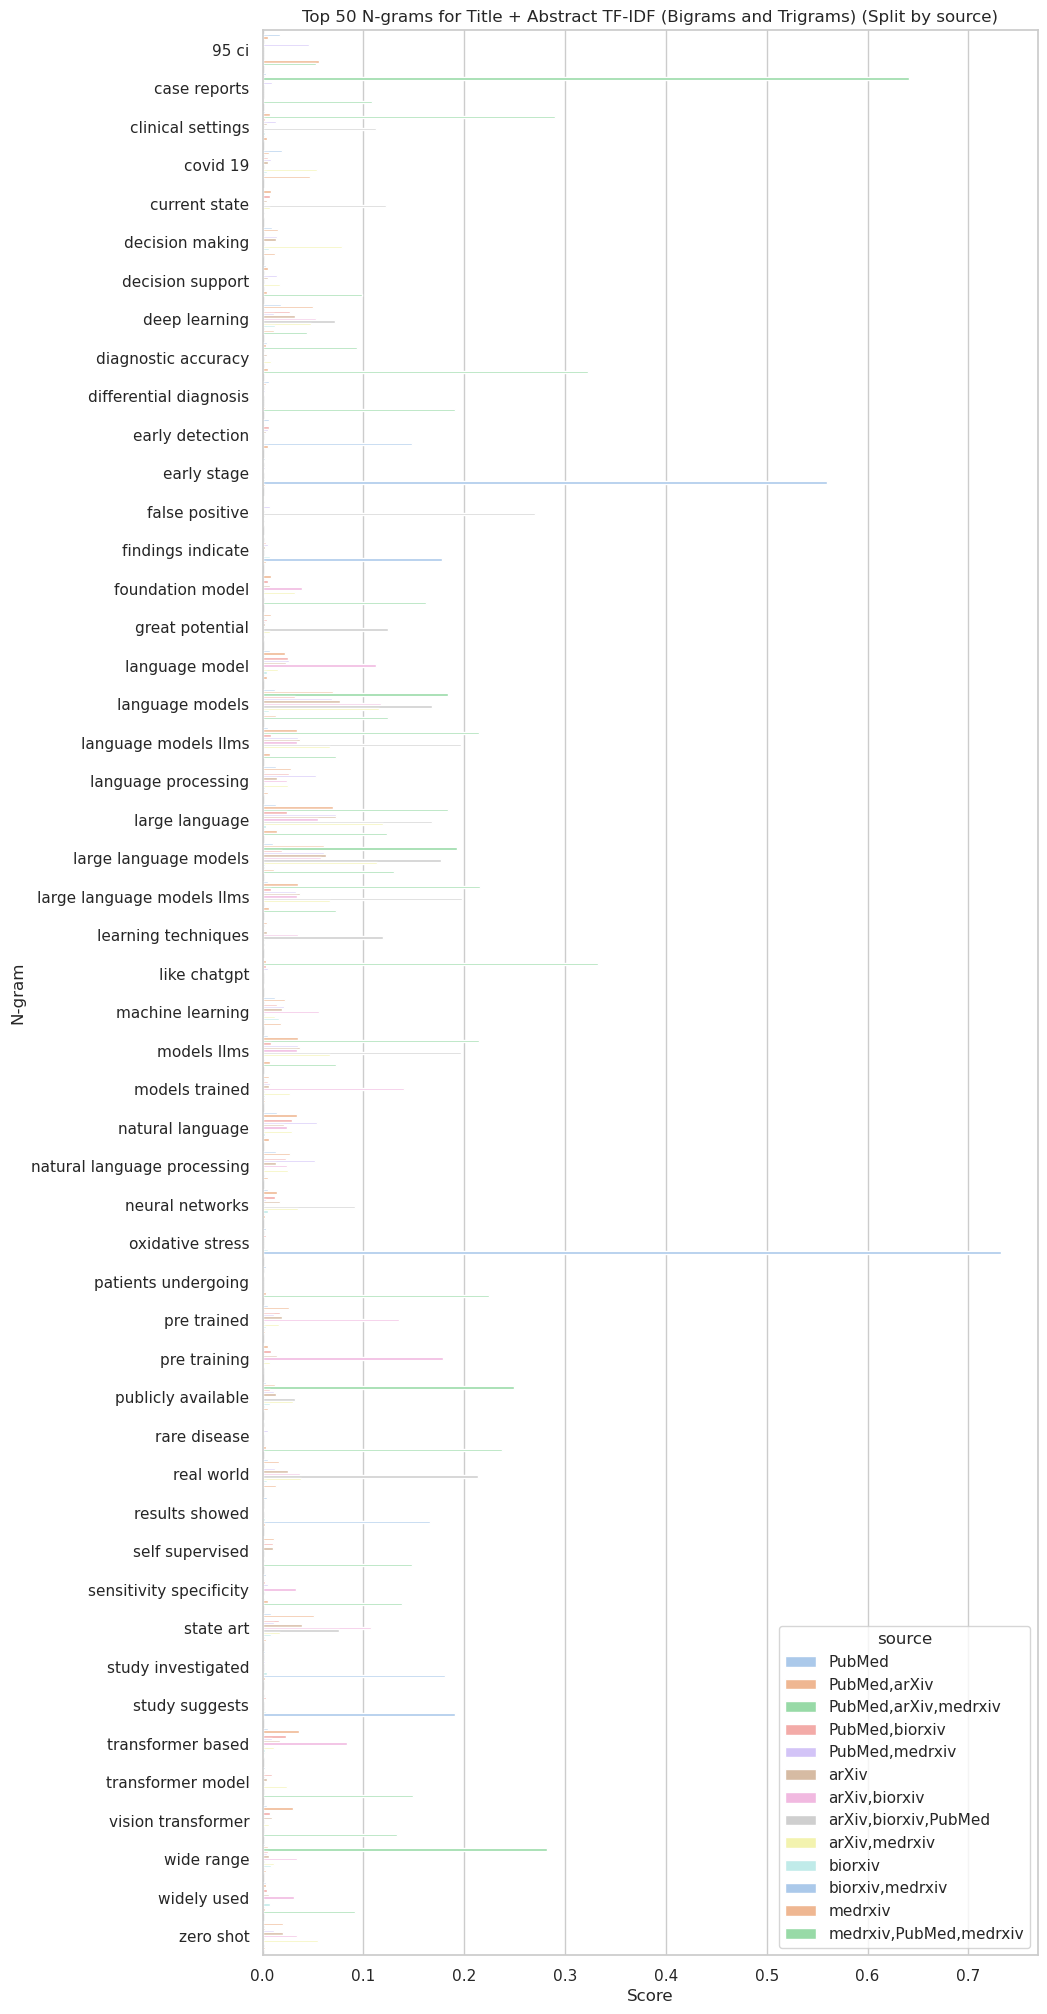

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# Modify the TF-IDF extraction function to handle n-grams
def extract_tfidf_and_frequency_ngrams(df, text_column, ngram_range=(2, 3)):
    # TF-IDF Vectorizer for bigrams and trigrams
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=ngram_range, max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[text_column])
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

    # Frequency (Count) Vectorizer for bigrams and trigrams
    count_vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range, max_features=1000)
    count_matrix = count_vectorizer.fit_transform(df[text_column])
    count_feature_names = count_vectorizer.get_feature_names_out()
    count_df = pd.DataFrame(count_matrix.toarray(), columns=count_feature_names)

    return tfidf_df, count_df

# Function to plot bigrams and trigrams with source column
def plot_top_ngrams_with_source(df, source_col, title, top_n=50):
    """
    Plots the top N n-grams from a DataFrame where each column represents a term
    (bigram or trigram) and each row represents a document, splitting bars based on the source column.
    """
    # Melt the dataframe to long format for seaborn, keeping the source column
    df_long = df.melt(id_vars=[source_col], var_name="term", value_name="score")
    
    # Group by source and term, and compute mean score per group
    df_grouped = df_long.groupby([source_col, "term"]).mean().reset_index()
    
    # Select the top N terms by average score across all sources
    top_terms = df_grouped.groupby("term")["score"].mean().sort_values(ascending=False).head(top_n).index
    df_top = df_grouped[df_grouped["term"].isin(top_terms)]
    
    # Plotting
    sns.set(style="whitegrid", palette="pastel")
    plt.figure(figsize=(10, 25))
    
    # Create a grouped bar plot where bars are split by source
    sns.barplot(x="score", y="term", hue=source_col, data=df_top, palette="pastel")
    
    # Customize the plot
    plt.title(f"Top {top_n} N-grams for {title} (Split by {source_col})")
    plt.xlabel("Score")
    plt.ylabel("N-gram")
    plt.legend(title=source_col)
    plt.show()

# Example usage:
# Extract bigrams and trigrams for title + abstract column
title_abstract_tfidf_ngrams, title_abstract_count_ngrams = extract_tfidf_and_frequency_ngrams(df, 'title_abstract', ngram_range=(2, 4))

# Assuming 'source' column is available in your dataframe (e.g., journal name, study type)
# Plot for title+abstract bigrams/trigrams TF-IDF, splitting bars by source
plot_top_ngrams_with_source(title_abstract_tfidf_ngrams.assign(source=df['source']), 'source', "Title + Abstract TF-IDF (Bigrams and Trigrams)")

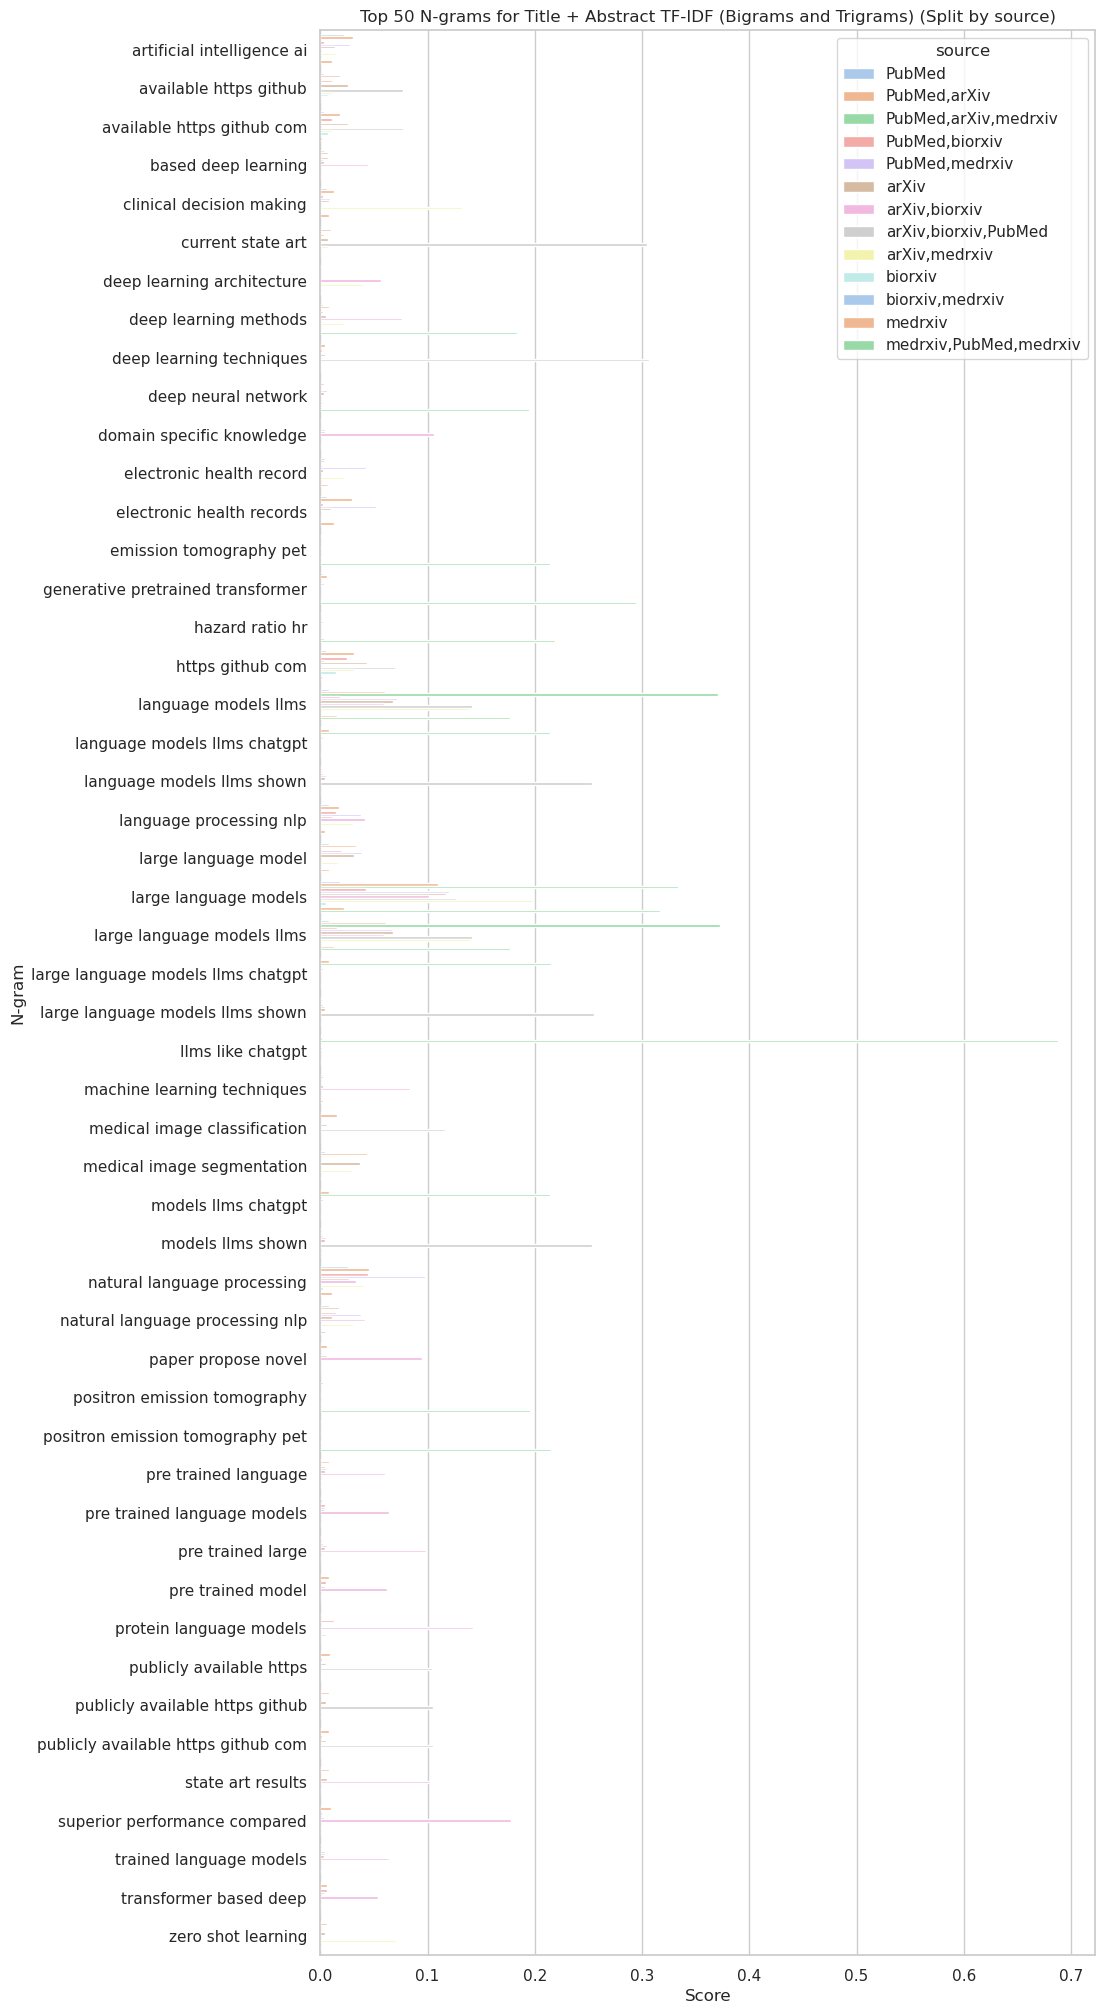

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# Modify the TF-IDF extraction function to handle n-grams
def extract_tfidf_and_frequency_ngrams(df, text_column, ngram_range=(2, 3)):
    # TF-IDF Vectorizer for bigrams and trigrams
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=ngram_range, max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[text_column])
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

    # Frequency (Count) Vectorizer for bigrams and trigrams
    count_vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range, max_features=1000)
    count_matrix = count_vectorizer.fit_transform(df[text_column])
    count_feature_names = count_vectorizer.get_feature_names_out()
    count_df = pd.DataFrame(count_matrix.toarray(), columns=count_feature_names)

    return tfidf_df, count_df

# Function to plot bigrams and trigrams with source column
def plot_top_ngrams_with_source(df, source_col, title, top_n=50):
    """
    Plots the top N n-grams from a DataFrame where each column represents a term
    (bigram or trigram) and each row represents a document, splitting bars based on the source column.
    """
    # Melt the dataframe to long format for seaborn, keeping the source column
    df_long = df.melt(id_vars=[source_col], var_name="term", value_name="score")
    
    # Group by source and term, and compute mean score per group
    df_grouped = df_long.groupby([source_col, "term"]).mean().reset_index()
    
    # Select the top N terms by average score across all sources
    top_terms = df_grouped.groupby("term")["score"].mean().sort_values(ascending=False).head(top_n).index
    df_top = df_grouped[df_grouped["term"].isin(top_terms)]
    
    # Plotting
    sns.set(style="whitegrid", palette="pastel")
    plt.figure(figsize=(10, 25))
    
    # Create a grouped bar plot where bars are split by source
    sns.barplot(x="score", y="term", hue=source_col, data=df_top, palette="pastel")
    
    # Customize the plot
    plt.title(f"Top {top_n} N-grams for {title} (Split by {source_col})")
    plt.xlabel("Score")
    plt.ylabel("N-gram")
    plt.legend(title=source_col)
    plt.show()

# Example usage:
# Extract bigrams and trigrams for title + abstract column
title_abstract_tfidf_ngrams, title_abstract_count_ngrams = extract_tfidf_and_frequency_ngrams(df, 'title_abstract', ngram_range=(3, 5))

# Assuming 'source' column is available in your dataframe (e.g., journal name, study type)
# Plot for title+abstract bigrams/trigrams TF-IDF, splitting bars by source
plot_top_ngrams_with_source(title_abstract_tfidf_ngrams.assign(source=df['source']), 'source', "Title + Abstract TF-IDF (Bigrams and Trigrams)")

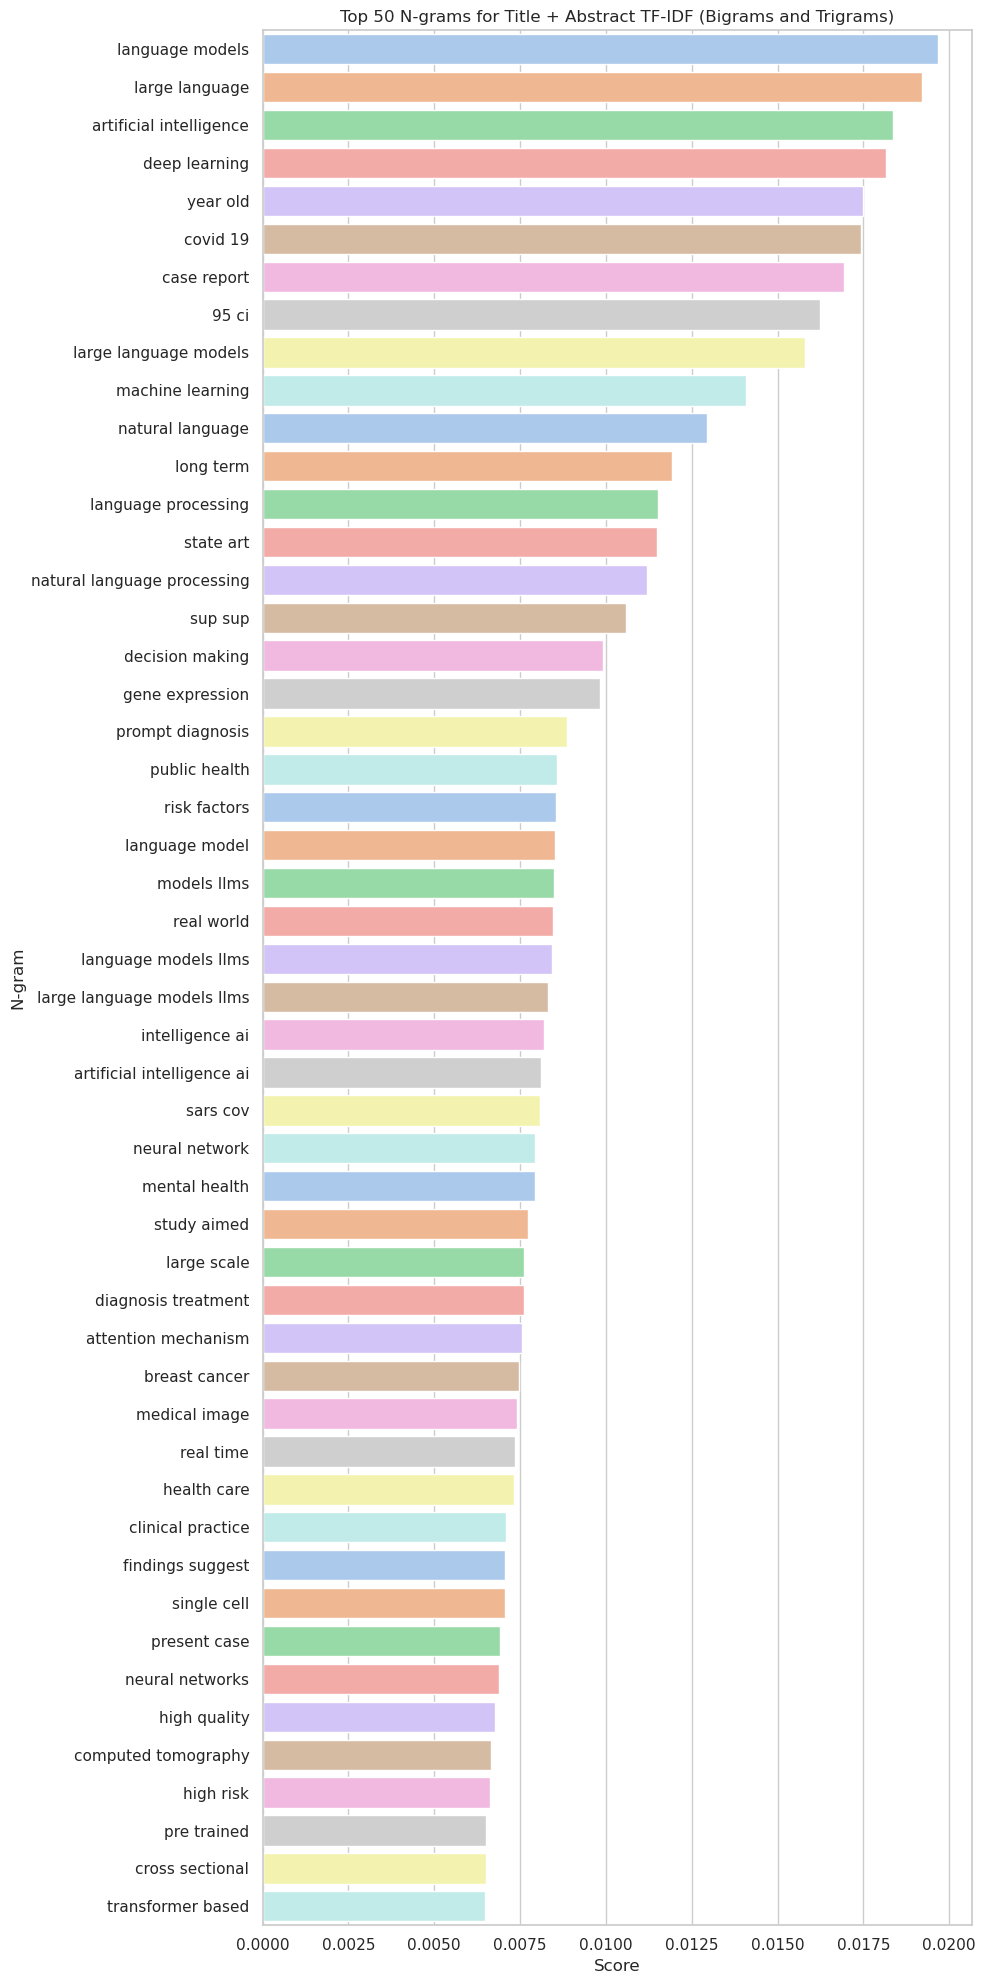

In [16]:
# Function to plot bigrams and trigrams without source splitting
def plot_top_ngrams(df, title, top_n=50, filepath=None):
    """
    Plots the top N n-grams from a DataFrame where each column represents a term
    (bigram or trigram) and each row represents a document.
    """
    # Get average scores per term
    term_scores = df.mean().sort_values(ascending=False).head(top_n)
    
    # Create a DataFrame for plotting
    term_df = pd.DataFrame({'term': term_scores.index, 'score': term_scores.values})
    
    # Plotting
    sns.set(style="whitegrid", palette="pastel")
    plt.figure(figsize=(10, 20))
    
    # Create a bar plot for top terms
    sns.barplot(x="score", y="term", data=term_df, palette="pastel")
    
    # Customize the plot
    plt.title(f"Top {top_n} N-grams for {title}")
    plt.xlabel("Score")
    plt.ylabel("N-gram")
    if filepath:
        plt.tight_layout()
        plt.savefig(filepath)    
    plt.show()
    plt.close()

# Example usage:
# Extract bigrams and trigrams for title + abstract column
title_abstract_tfidf_ngrams, title_abstract_count_ngrams = extract_tfidf_and_frequency_ngrams(df, 'title_abstract', ngram_range=(2, 4))

# Plot for title+abstract bigrams/trigrams TF-IDF
plot_top_ngrams(title_abstract_tfidf_ngrams, "Title + Abstract TF-IDF (Bigrams and Trigrams)", filepath = 'imgs/SF1.pdf')

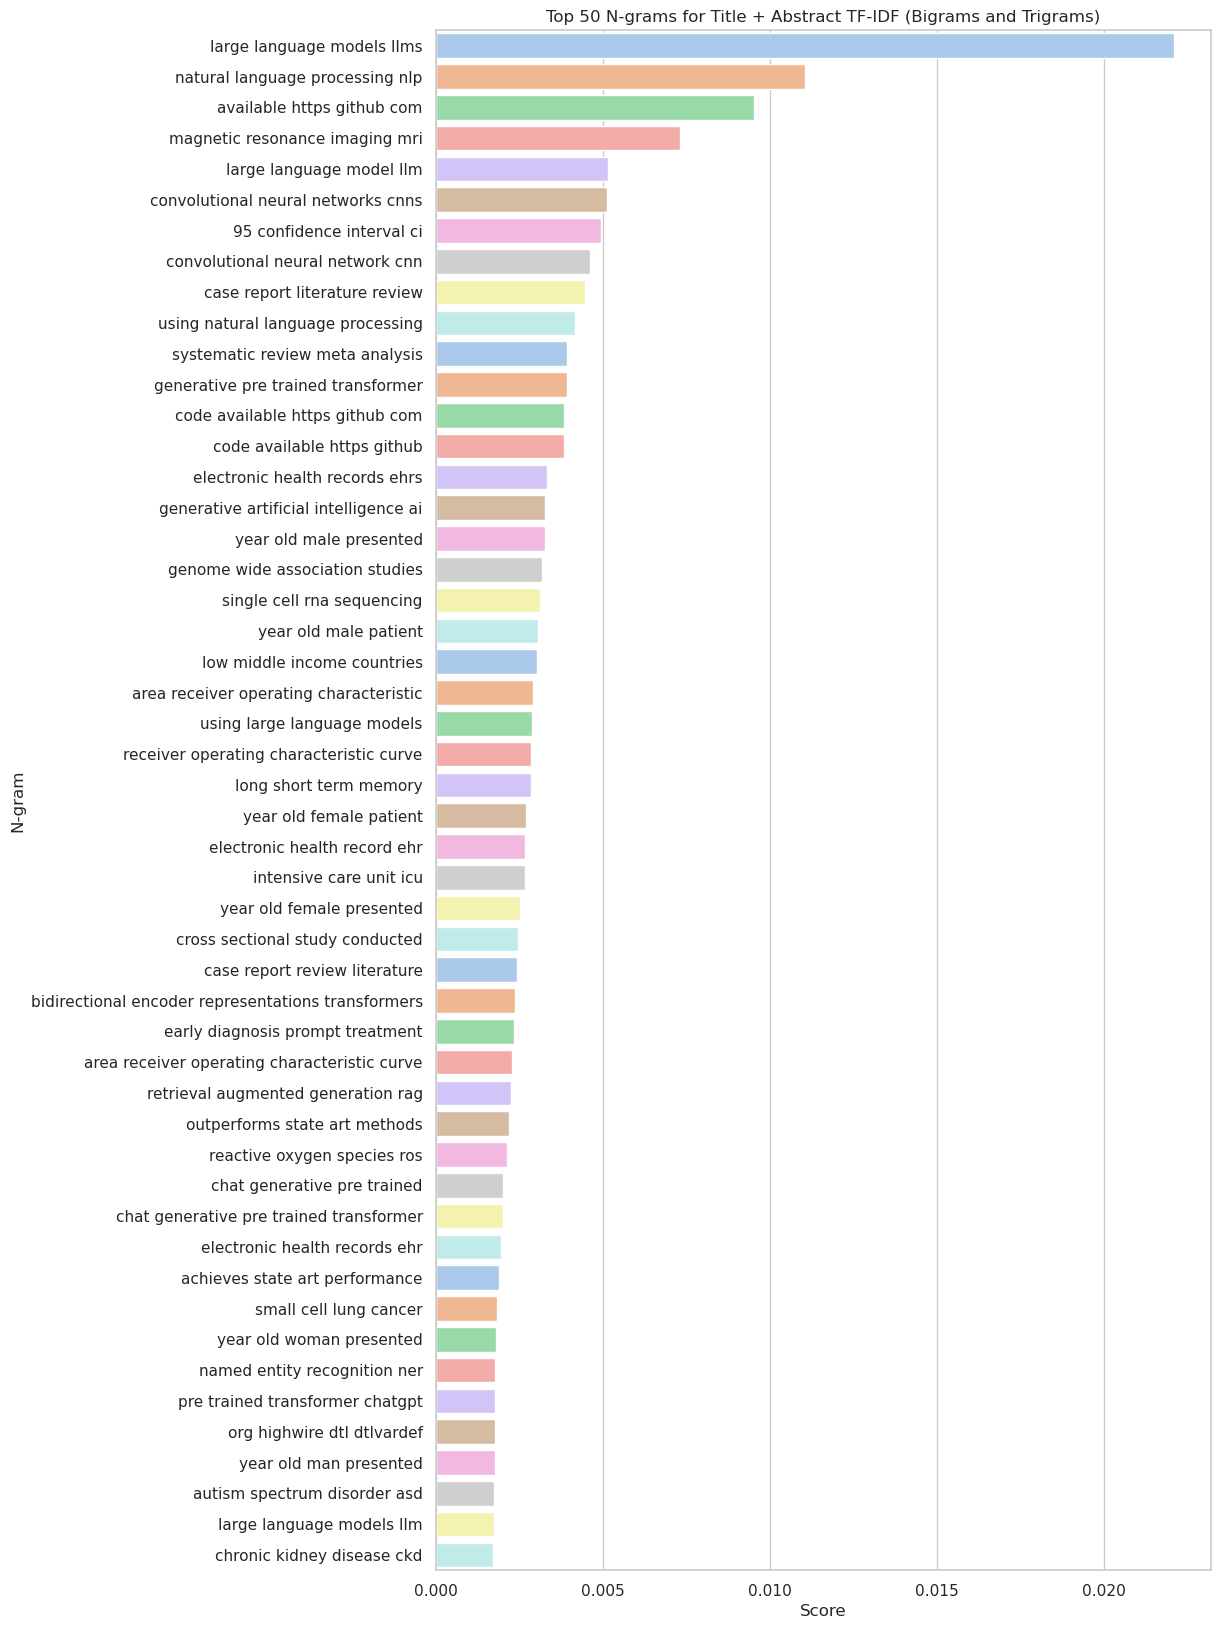

In [17]:
# Example usage:
# Extract bigrams and trigrams for title + abstract column
title_abstract_tfidf_ngrams, title_abstract_count_ngrams = extract_tfidf_and_frequency_ngrams(df, 'title_abstract', ngram_range=(4, 6))

# Plot for title+abstract bigrams/trigrams TF-IDF
plot_top_ngrams(title_abstract_tfidf_ngrams, "Title + Abstract TF-IDF (Bigrams and Trigrams)")

## Exclude some words

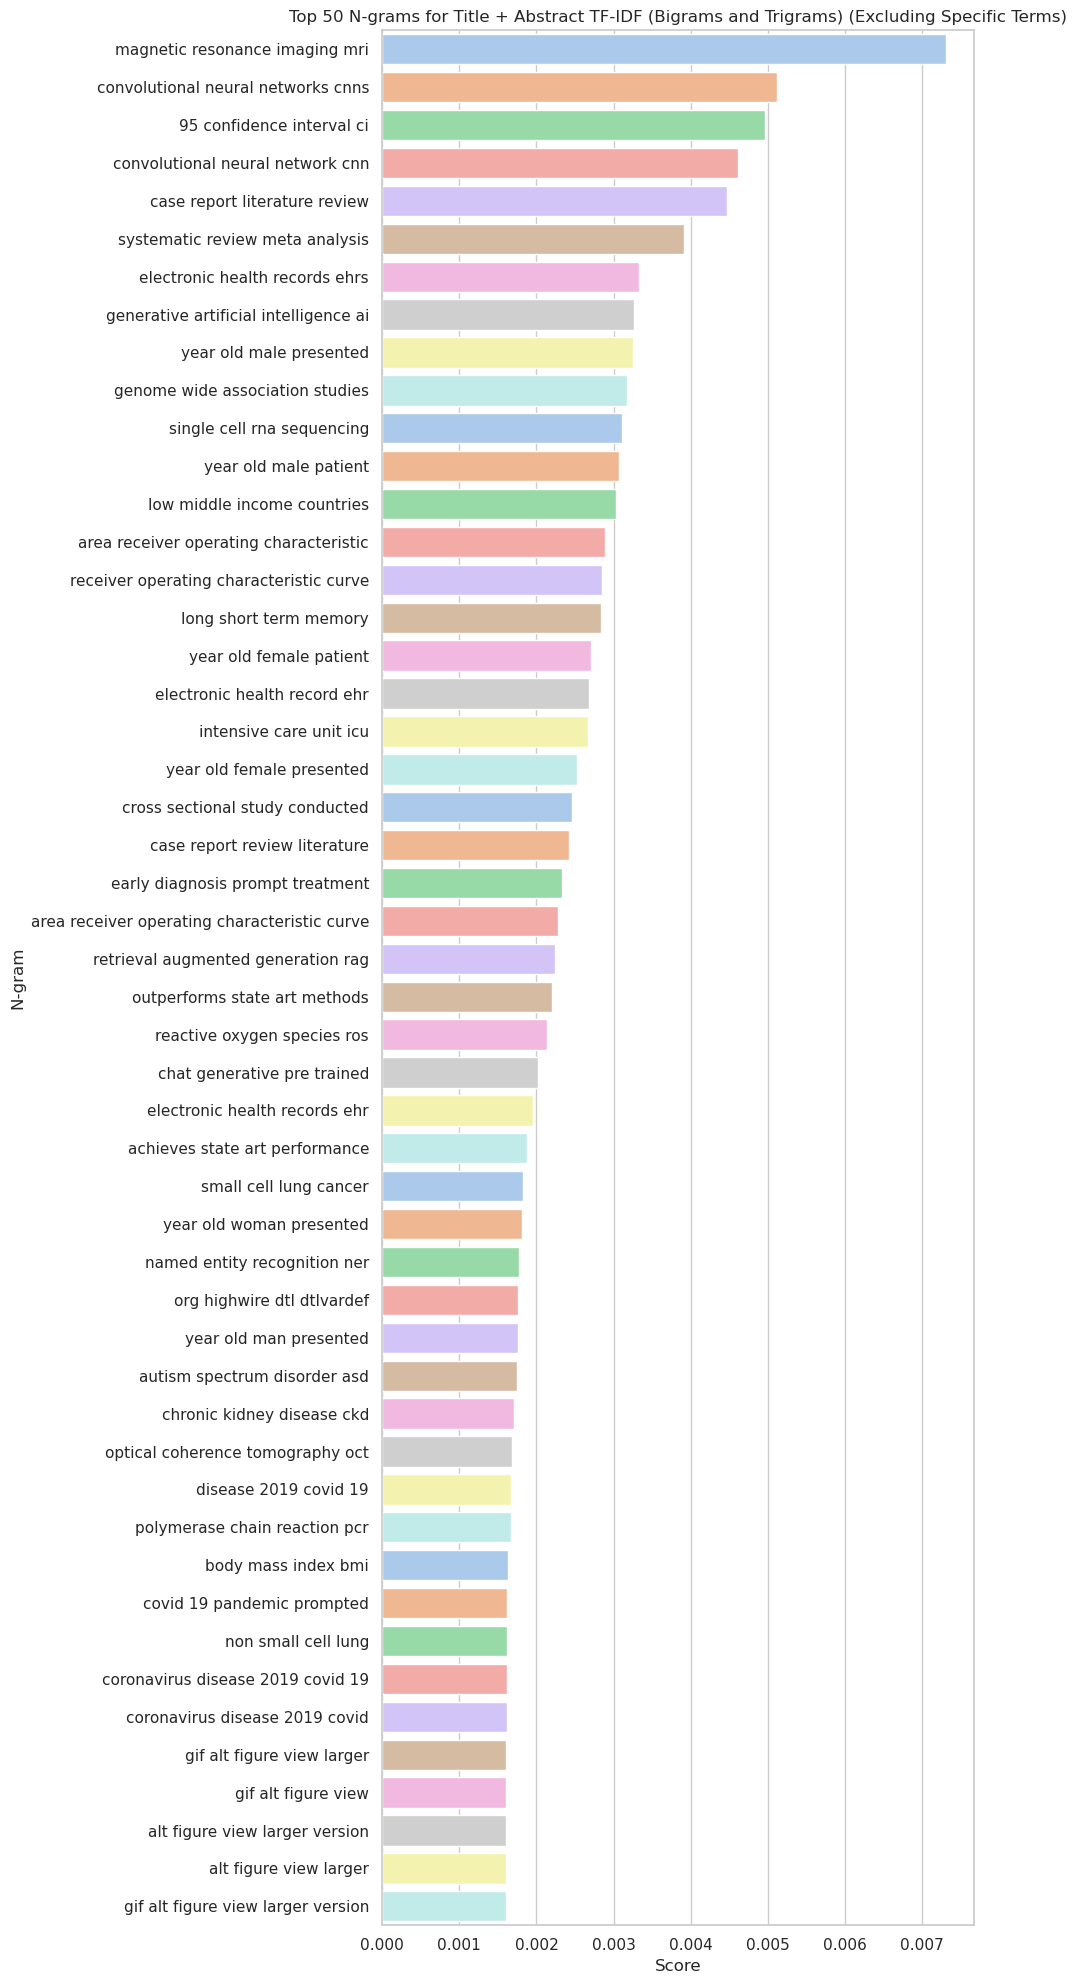

In [18]:
# Function to plot bigrams and trigrams without source splitting, excluding specific n-grams
def plot_top_ngrams_with_exclusion(df, title, top_n=50, exclude_terms=None, filepath=None):
    """
    Plots the top N n-grams from a DataFrame where each column represents a term
    (bigram or trigram) and each row represents a document. Excludes specific terms.
    """
    if exclude_terms is None:
        exclude_terms = ['language', 'model', 'models', 'learning', 'llm', 'llms']

    # Get average scores per term
    term_scores = df.mean().sort_values(ascending=False)
    
    # Filter out n-grams that contain any of the excluded terms
    filtered_term_scores = term_scores[~term_scores.index.str.contains('|'.join(exclude_terms))]
    
    # Select the top N terms after filtering
    top_terms = filtered_term_scores.head(top_n)
    
    # Create a DataFrame for plotting
    term_df = pd.DataFrame({'term': top_terms.index, 'score': top_terms.values})
    
    # Plotting
    sns.set(style="whitegrid", palette="pastel")
    plt.figure(figsize=(10, 20))
    
    # Create a bar plot for top terms
    sns.barplot(x="score", y="term", data=term_df, palette="pastel")
    
    # Customize the plot
    plt.title(f"Top {top_n} N-grams for {title} (Excluding Specific Terms)")
    plt.xlabel("Score")
    plt.ylabel("N-gram")
    if filepath:
        plt.tight_layout()
        plt.savefig(filepath)
    
    plt.show()
    plt.close()

# Example usage:
# Extract bigrams and trigrams for title + abstract column
title_abstract_tfidf_ngrams, title_abstract_count_ngrams = extract_tfidf_and_frequency_ngrams(df, 'title_abstract', ngram_range=(4,6))

# Plot for title+abstract bigrams/trigrams TF-IDF, excluding specific terms
plot_top_ngrams_with_exclusion(title_abstract_tfidf_ngrams, 
                               "Title + Abstract TF-IDF (Bigrams and Trigrams)", 
                               exclude_terms=['language', 'model', 'models', 'learning', 'llm', 'llms', 'github', 'transformer'],
                               filepath = 'imgs/SF2.pdf')


## Save clinical

(51613, 5)
['LLM', 'large language model', 'NLP', 'natural language processing', 'GPT', 'chatGPT', 'transformer', 'BERT', 'Bidirectional Encoder Representation', 'RAG', 'augmented generation', 'generative AI', 'AI assistant', 'prompt engineering', 'chatbot', 'prompt engineering', 'attention mechanism', 'chain-of-thought', 'chain of thought']
(19746, 5)
['electronic health record', 'ehr', 'clinical', 'case report', 'cds', 'intensive care unit', 'medical', 'syndrome', 'phenotype', 'complex trait']
(12537, 5)
['inherit', 'heredit', 'heritability', 'gwas', 'genome-wide', 'genome wide', 'association stud', 'snp', 'single nucleotide', 'genetic', 'variant interpretation', 'genomic varia', 'human gen', 'NGS', 'generation sequencing']
(577, 5)
(576, 5)


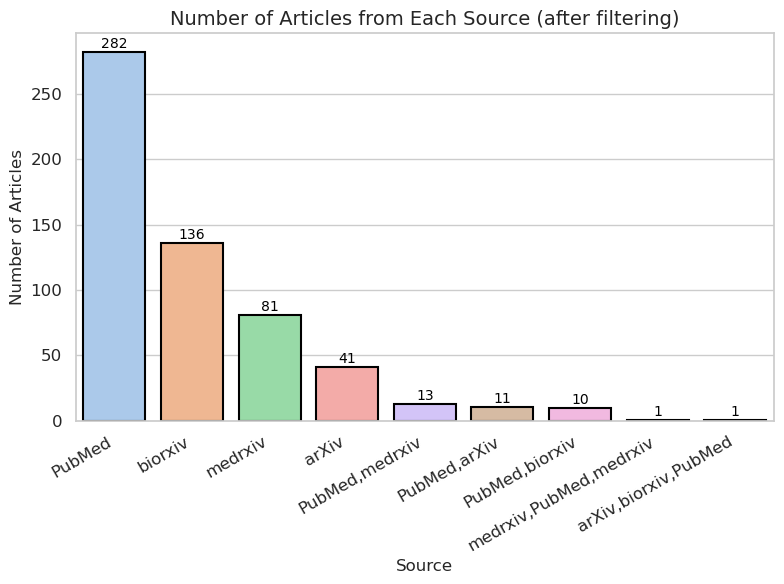

In [19]:
def delete_list(x, list_strings):
    x = x.lower()
    for string in list_strings:
        x = x.replace(string, "+_+")
    return x


def filter_df(df, phrases_to_include, column="title_abstract"):
    filter_condition = df[column].str.contains(
        "|".join(phrases_to_include), case=False, na=False
    )
    return df[filter_condition]


phrases_to_include_list = [
    [
        "LLM",
        "large language model",
        "NLP", 
        "natural language processing",
        "GPT",
        "chatGPT",
        "transformer",
        "BERT",
        "Bidirectional Encoder Representation",
        "RAG",
        "augmented generation",
        "generative AI",
        "AI assistant",
        "prompt engineering",
        "chatbot",
        "prompt engineering",
        "attention mechanism",
        "chain-of-thought",
        "chain of thought",
    ],
    [
        "electronic health record",
        "ehr",
        "clinical",
        "case report",
        "cds",
        "intensive care unit",
        "medical",
        "syndrome",
        "phenotype",
        "complex trait",
    ],
    [
        "inherit",
        "heredit",
        "heritability",
        "gwas",
        "genome-wide",
        "genome wide",
        "association stud",
        "snp",
        "single nucleotide",
        "genetic",
        "variant interpretation",
        "genomic varia",
        "human gen",
        "NGS",
        "generation sequencing",
    ],
]

words_to_remove = [
    "tragic",
    "fragment",
    "coverag",
    "encourag",
    "ungs",
    "angs",
    "ongs",
    "ings",
    "eragrostis",
    "smallmouth",
    "fragile",
    "angptl",
    "intragenic",
    "fragment",
    "hallmark",
    "uvrag",
    "leverag",
    "storag",
    "averag",
    "coverag",
    "encourag",
    "forage",
    "liraglutid",
]

df_cleaned_clinic = deepcopy(df)

df_cleaned_clinic["title_abstract_removed"] = df_cleaned_clinic["title_abstract"].apply(
    lambda x: delete_list(x, words_to_remove)
)


print(df_cleaned_clinic.shape)
for phrases_to_include in phrases_to_include_list:
    print(phrases_to_include)
    df_cleaned_clinic = filter_df(
        df_cleaned_clinic, phrases_to_include, "title_abstract_removed"
    )[["title", "abstract", "source", "title_abstract", "title_abstract_removed"]]
    #     df_cleaned_clinic = filter_df(df_cleaned_clinic, phrases_to_include, 'title_abstract')[['title', 'abstract', 'source', 'title_abstract', 'title_abstract_removed']]
    print(df_cleaned_clinic.shape)

df_cleaned_clinic = df_cleaned_clinic[
    ~df_cleaned_clinic.abstract.apply(lambda x: str(x) == "nan")
]
print(df_cleaned_clinic.shape)
df_cleaned_clinic[
    [
        "title",
        "abstract",
        "source",
    ]
].to_csv(os.path.join(DATA_DIR, "clinic_genetic.csv"), index=False)
after_filtering = plot_article_source_histogram(df_cleaned_clinic, save_path="imgs/Fig2_b.pdf", title='Number of Articles from Each Source (after filtering)', up_size=3)

## In total we have:

In [13]:
len(set(df_cleaned_clinic.title))

576

In [12]:
df_cleaned_clinic

,title,abstract,source,title_abstract,title_abstract_removed
26,Natural Language Processing and Schizophrenia:...,(1) Background: Approximately 1% of the global...,PubMed,Natural Language Processing and Schizophrenia:...,natural language processing and schizophrenia:...
61,Harnessing generative AI to annotate the sever...,0.1There are thousands of human phenotypes whi...,medrxiv,Harnessing generative AI to annotate the sever...,harnessing generative ai to annotate the sever...
79,Leveraging hierarchical structures for genetic...,1.Initially introduced in 1909 by William Bate...,"PubMed,medrxiv",Leveraging hierarchical structures for genetic...,+_+ing hierarchical structures for genetic blo...
88,16S rRNA gene sequencing for bacterial identif...,16S rRNA gene sequence is the most common hous...,biorxiv,16S rRNA gene sequencing for bacterial identif...,16s rrna gene sequencing for bacterial identif...
106,A Systematic Review of Testing and Evaluation ...,1ImportanceLarge Language Models (LLMs) can as...,medrxiv,A Systematic Review of Testing and Evaluation ...,a systematic review of testing and evaluation ...
...,...,...,...,...,...
50989,A self-supervised framework for learning whole...,Whole slide imaging is fundamental to biomedic...,arXiv,A self-supervised framework for learning whole...,a self-supervised framework for learning whole...
51091,Machine learning-based donor permission extrac...,With more clinical trials are offering optiona...,PubMed,Machine learning-based donor permission extrac...,machine learning-based donor permission extrac...
51215,Accuracy of generative artificial intelligence...,With the increasing development of artificial ...,PubMed,Accuracy of generative artificial intelligence...,accuracy of generative artificial intelligence...
51230,Enhancing human phenotype ontology term extrac...,With the increasing utilization of exome and g...,PubMed,Enhancing human phenotype ontology term extrac...,enhancing human phenotype ontology term extrac...


# For report - phrases to include and to remove

In [81]:
a, b, c = phrases_to_include_list


print(", ".join(a), end='\n\n')
print(", ".join(b), end='\n\n')
print(", ".join(c), end='\n\n')

LLM, large language model, NLP, natural language processing, GPT, chatGPT, transformer, BERT, Bidirectional Encoder Representation, RAG, augmented generation, generative AI, AI assistant, prompt engineering, chatbot, prompt engineering, attention mechanism, chain-of-thought, chain of thought

electronic health record, ehr, clinical, case report, cds, intensive care unit, medical, syndrome, phenotype, complex trait

inherit, heredit, heritability, gwas, genome-wide, genome wide, association stud, snp, single nucleotide, genetic, variant interpretation, genomic varia, human gen, NGS, generation sequencing



In [82]:
print(", ".join(words_to_remove))

tragic, fragment, coverag, encourag, ungs, angs, ongs, ings, eragrostis, smallmouth, fragile, angptl, intragenic, fragment, hallmark, uvrag, leverag, storag, averag, coverag, encourag, forage, liraglutid


# For report -- image with all histograms

In [63]:
# Select also newly made final version
df_selected_filtered = pd.read_csv('data/ST2.csv')[['title', 'abstract', 'source', 'code']].dropna()
df_selected_filtered

,title,abstract,source,code
0,A systematic review and meta-analysis of diagn...,While generative artificial intelligence (AI) ...,Pubmed,0.0
1,Addressing the Gaps in Early Dementia Detectio...,The rapid global aging trend has led to an inc...,arXiv,0.0
2,Artificial intelligence in clinical genetics,Artificial intelligence (AI) has been growing ...,PubMed,0.0
3,Bioinformatics and Biomedical Informatics with...,The year 2023 marked a significant surge in th...,"arXiv,PubMed",0.0
4,Chatbot Artificial Intelligence for Genetic Ca...,Most individuals with a hereditary cancer synd...,PubMed,0.0
...,...,...,...,...
182,Large language models identify causal genes in...,Identifying underlying causal genes at signifi...,medrxiv,514.0
183,OpenAI o1-Preview vs. ChatGPT in Healthcare: A...,This editorial explores the recent advancement...,PubMed,514.0
184,A platform for the biomedical application of l...,Current-generation Large Language Models (LLMs...,Pubmed,514.0
185,BioAgents: Democratizing Bioinformatics Analys...,Creating end-to-end bioinformatics workflows r...,arxiv,514.0


/tmp/ipykernel_62748/2162260389.py:30: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_62748/2162260389.py:30: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_62748/525396123.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


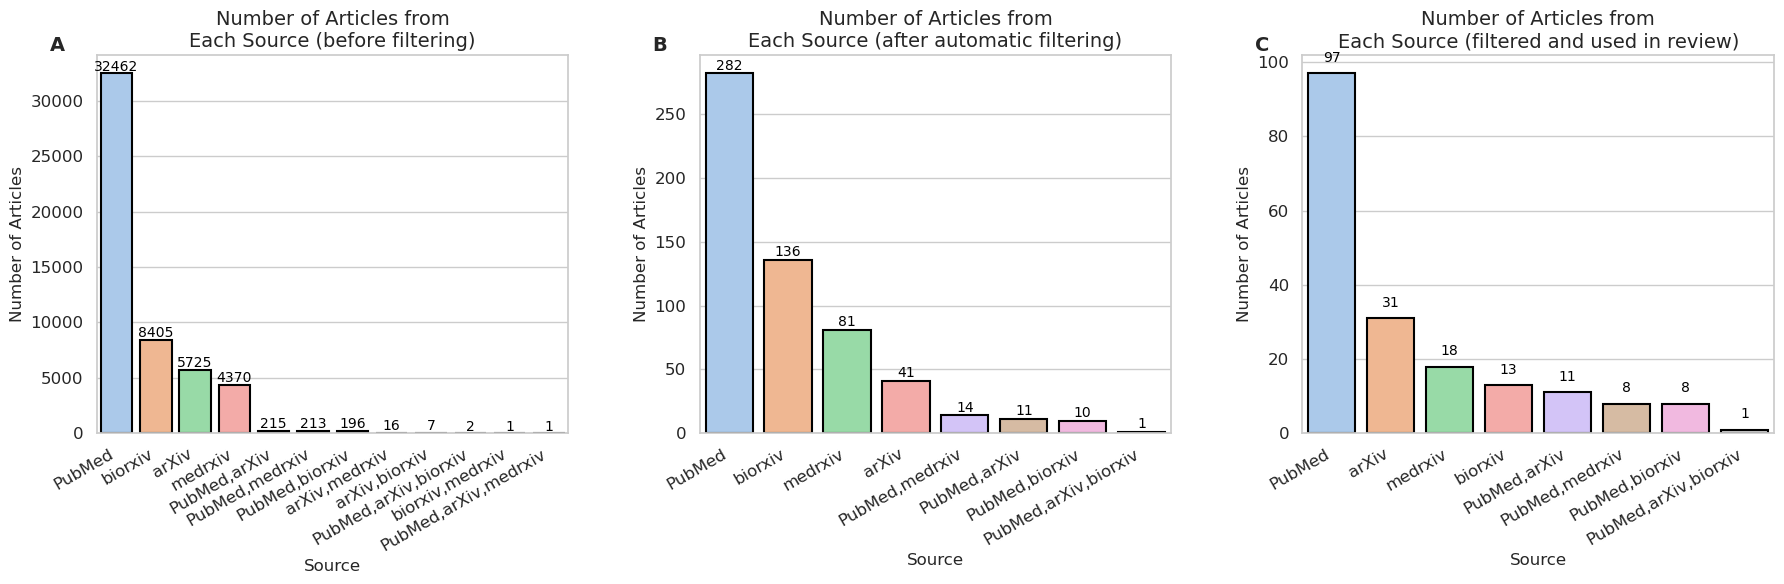

In [64]:
# clean source
df.source = df.source.apply(lambda x: doubled_sources[x] if x in doubled_sources else x)
df_cleaned_clinic.source = df_cleaned_clinic.source.apply(lambda x: doubled_sources[x] if x in doubled_sources else x)
df_selected_filtered.source = df_selected_filtered.source.apply(lambda x: doubled_sources[x] if x in doubled_sources else x)


# create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Use modified function that accepts `ax`
plot_article_source_histogram(df, title='Number of Articles from\nEach Source (before filtering)',
                              up_size=250,
                              ax=ax1)
plot_article_source_histogram(df_cleaned_clinic, title='Number of Articles from\nEach Source (after automatic filtering)',
                              up_size=3,
                              ax=ax2)
plot_article_source_histogram(df_selected_filtered, title='Number of Articles from\nEach Source (filtered and used in review)',
                              up_size=3,
                              ax=ax3)

# Add "A" and "B" to top-left of each subplot
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold', ha='left', va='top')
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold', ha='left', va='top')
ax2.text(-0.1, 1.05, 'C', transform=ax3.transAxes, fontsize=14, fontweight='bold', ha='left', va='top')

plt.tight_layout()

# Save and show
fig.savefig('imgs/fig2.pdf', format='pdf')
plt.show()